In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
from numpy import arange
import math
import xml.etree.ElementTree as ET

import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import cm
from scipy.optimize import curve_fit

In [3]:
a = np.zeros(96,dtype=int)
np.save('ratio_1.npy', a) 
np.save('ratio_2.npy', a)

dataframe = pd.DataFrame()
dataframe.to_pickle("graph_data.pkl")

print(np.load('ratio_1.npy'))
print(np.load('ratio_2.npy'))
def timescale(x):
    fulltime = range(x)
    t = []
    for a in fulltime:
        t.append(a*.5)
    print(t)
    
def objective(x,a,b):
    return a+b*np.log(x)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [4]:
def clean_data(file_path):

    print('Importing Data_file...')
    tree = ET.parse(file_path)
    root = tree.getroot()

    print('---------------')



    platesection_df = pd.DataFrame(columns = ['Name','InstrumentInfo', 'ReadTime'])
    wells_df = pd.DataFrame(columns = ['WellID','Name','Row','Col'])
    wavelengths = []
    absorbances = []
    timedata = []
    # Moving to each PlateSection output. Here we can collect plate name and read time info
    # Additionally could add support for read mode and type 


    print('Cleaning data...')
    for section in root.findall('./PlateSections/PlateSection'):
        print(section.attrib)

        for node in section.iter('Wavelength'):
            #node.attrib are going to be small disctionaries that pertain to:
            # 	{'Index': '1'}
            #	{'Index': '2'}
            #	{'WavelengthIndex': '1'}
            #	{'WavelengthIndex': '2'}
            # We can pull emission values from the 'Index' keys and then correlate that to the plate
            # with the 'WavelengthIndex' keys.


            # Getting emission wavelengths:
            temp_dict = node.attrib
            print(temp_dict.keys())
            if list(temp_dict.keys())[0] == 'Index':
                if temp_dict['Index'] == '1':
                    wave_1 = node.find('Emission').text
                    print('Wavelength 1 identified as: ',wave_1,'nm')
                elif temp_dict['Index'] == '2':
                    wave_2 = node.find('Emission').text
                    print('Wavelength 2 identified as: ',wave_2,'nm')
                    
        for node in section.iter('Well'):
            #print(node.attrib)
            #print(node.find('RawData').text)
            el_check = ET.iselement(node.find('RawData'))
            if el_check == True:

                #Populating all of the data to corresponding dataframes at the index of each well
                platesection_df = platesection_df.append(section.attrib,ignore_index=True)
                wells_df = wells_df.append(node.attrib,ignore_index=True)



                absorbances.append(node.find('RawData').text)
                #wavelengths.append(wave_temp)
                kinetic_check = ET.iselement('TimeData')
                if kinetic_check == True:
                    absorbances.append(node.find('TimeData').text)
    num_abs = len(absorbances)
    counter = int(num_abs / 192)
    print(counter)
    for x in range(0,counter):
        wave_1 = int(wave_1)
        wave_2 = int(wave_2)
        wavelengths.append([wave_1]*96)
        wavelengths.append([wave_2]*96)


    wavelengths = np.concatenate(wavelengths)
    wells_df['RawData'] = absorbances
    wells_df['Wavelength'] = wavelengths
    if kinetic_check == True:
        wells_df['TimeData'] = timedata


    Data = pd.concat([wells_df, platesection_df], axis=1)
    Data.columns = ['WellID','Well Position','Row','Col','RawData','Wavelength','Plate','InstrumentInfo','ReadTime']
    Data = Data.drop(['Row','Col'],axis=1)

    excel_path = file_path.replace('.xml','.xlsx')



    Data.to_excel(excel_path)
    


    print('Cleaned File!')
    ##Remove background noise and create ratios only for wells that contain polymer
    i=0
    j=0
    k=0
    a615 = []
    a632 = []
    absorbances = list(map(float, absorbances))
    if counter ==1:
        a615_raw = absorbances[0:96]
        a632_raw = absorbances[96:192]
    else:
        a615_raw = absorbances[96*(2*counter-2):96*(2*counter-1)]
        a632_raw = absorbances[96*(2*counter-1):96*(2*counter)]

    for x in a615_raw:
        if x > 15:
            a615.append(a615_raw[i])
        else:
            a615.append(0)
        i = i+1

    
    for x in a632_raw:
        if x > 15:
            a632.append(a632_raw[j])
        else:
            a632.append(0)
        j = j+1

    #print(a632)
    #print(a615)
    #Create array of ratios for wells
    ratio = []

    for x in a632:
        if x > 0:
            ratio.append(a632[k]/a615[k])
        else:
            ratio.append(0)
        k = k+1

    #print('Ratio = ',ratio)

    #Array of zeros needs to be initialized before doing data analysis
    #Run 'arraysave.py' to initiailize
    n = 0
    m=0
    first = np.load('ratio_1.npy')
    second = np.load('ratio_2.npy')
    #print(first)
    slope_ratio_1 = []
    slope_ratio_2 = []
    for x in ratio:
        if x > 0:
            slope_ratio_1.append(((ratio[n]-first[n])/30))
        else:
            slope_ratio_1.append(0)
        n = n+1 
    
    np.save('ratio_1.npy', ratio)
    np.save('ratio_2.npy', first)
    
    for x in first:
        if x > 0:
            slope_ratio_2.append(((first[m]-second[m])/30))
        else:
            slope_ratio_2.append(0)
        m = m+1
    
    
    #post_first = np.load('ratio_1.npy')
    #post_second = np.load('ratio_2.npy')
    

    #print('First = ',post_first)
    #print('Second = ',post_second)


    #Create binary data to send to Arduino out of calculated ratio slopes
    thresh_1 = []
    thresh_2 = []
    for x in slope_ratio_1:
     if abs(x) < .002:
         thresh_1.append(0)
     elif x ==0:
        thresh_1.append(0)
     else:
        thresh_1.append(1)
    
    for y in slope_ratio_2:
     if abs(y) < .002:
         thresh_2.append(0)
     elif y ==0:
        thresh_2.append(0)
     else:
        thresh_2.append(1) 
        
    thresh = []
    z = 0
    for x in thresh_1:
        if (thresh_1[z] == 0 and thresh_2[z] == 0):
            thresh.append(0)
        else:
            thresh.append(1)
        z = z+1
        
    
    
    print('Thresh 1 = ', thresh_1)
    print('Thresh 2 = ', thresh_2)
    print('Final thresh = ', thresh)
    
    
    bits = [[1,2,4,8,16,32,64,128,256,512,1024,2048],
            [1,2,4,8,16,32,64,128,256,512,1024,2048],
            [1,2,4,8,16,32,64,128,256,512,1024,2048],
            [1,2,4,8,16,32,64,128,256,512,1024,2048],
            [1,2,4,8,16,32,64,128,256,512,1024,2048],
            [1,2,4,8,16,32,64,128,256,512,1024,2048],
            [1,2,4,8,16,32,64,128,256,512,1024,2048],
            [1,2,4,8,16,32,64,128,256,512,1024,2048]]
    #binary = thresh[96:192]

    #Create array that communicates with Arduino that tells it which LED's to turn on
    binary = np.array(thresh).reshape(8,12)
    byte_data = binary*bits
    print('Byte data = \n', byte_data)
    global input_data
    input_data = []
    rows = len(byte_data)
    cols = len(byte_data[0])
    total = 0
    for x in range(0,rows):
        rowtotal=0
        for y in range(0,cols):
            rowtotal=rowtotal+int(byte_data[x][y])
        input_data.append(rowtotal)

   
    well_pos = np.array(Data['Well Position'])
    
    print('Data to send Arduino = ', input_data)
    graph = []
    name = []

    for d in range(len(ratio)):
        if ratio[d] >0:
            graph.append(ratio[d])
            name.append(well_pos[d])

    print(graph)
    print(name)

    timescale(10)

    #Create dataframe with all ratios each run
    clean_ratio = []
    for x in ratio:
        if x > 0:
            clean_ratio.append(x)

    clean_ratio = np.array(clean_ratio).reshape(1,len(name))

    graph_data = pd.read_pickle("graph_data.pkl")

    graph_data2 = pd.DataFrame(clean_ratio, columns = name)
    graph_data = graph_data.append(graph_data2, ignore_index = True)
    graph_data.to_pickle("graph_data.pkl")
    print(graph_data)

    #Determine if polymerization is finished by looking at byte_data array.
    #A byte_data array of all zeros means reaction is complete
    eval = byte_data.reshape(1,96)
    
    finish = None
    
    if byte_data.any() > 0: 
        finish = False
    else:
        finish = True

    if finish == True:
        pyplot.legend(graph_data.columns.tolist(),loc='center left', bbox_to_anchor=(1, 0.5))
        graph_data.plot(kind = 'line',title='Fluorescence Ratio vs. Time', grid=True)
        pyplot.legend(graph_data.columns.tolist(),loc='center left', bbox_to_anchor=(1, 0.5))
        graph_data.to_excel('Experiment_Data.xlsx')
        plt.show()

In [9]:
clean_data(r"C:\Users\twinj\Desktop\SampleData\SampleData1_5.xml")

Importing Data_file...
---------------
Cleaning data...
{'Name': 'LED t=0', 'InstrumentInfo': 'SpectraMax M2\nROM v3.0.22 16Feb11', 'ReadTime': '11:56 AM 1/20/2021'}
dict_keys(['Index'])
Wavelength 1 identified as:  615 nm
dict_keys(['Index'])
Wavelength 2 identified as:  632 nm
dict_keys(['WavelengthIndex'])
dict_keys(['WavelengthIndex'])
{'Name': 'Lamp t=0', 'InstrumentInfo': 'SpectraMax M2\nROM v3.0.22 16Feb11', 'ReadTime': '11:57 AM 1/20/2021'}
dict_keys(['Index'])
Wavelength 1 identified as:  615 nm
dict_keys(['Index'])
Wavelength 2 identified as:  632 nm
dict_keys(['WavelengthIndex'])
dict_keys(['WavelengthIndex'])
{'Name': 'LED t=.5', 'InstrumentInfo': 'SpectraMax M2\nROM v3.0.22 16Feb11', 'ReadTime': '12:35 PM 1/20/2021'}
dict_keys(['Index'])
Wavelength 1 identified as:  615 nm
dict_keys(['Index'])
Wavelength 2 identified as:  632 nm
dict_keys(['WavelengthIndex'])
dict_keys(['WavelengthIndex'])
{'Name': 'Lamp t=.5', 'InstrumentInfo': 'SpectraMax M2\nROM v3.0.22 16Feb11', 'ReadT

[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5]
For A1: y = 1.27119 + 0.54154 * log(x) 
For C12: y = 1.31583 + 0.59404 * log(x) 
For D7: y = 1.40379 + 0.64419 * log(x) 
For F3: y = 1.38654 + 0.63227 * log(x) 
For G10: y = 1.36917 + 0.63515 * log(x) 


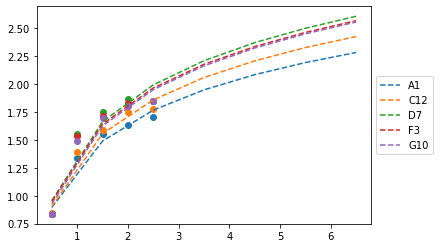

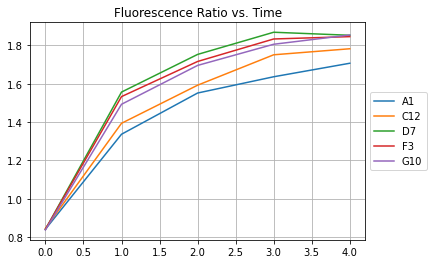

In [10]:
graph_data = pd.read_pickle("graph_data.pkl")

timescale(22)

for (columnName, columnData) in graph_data.iteritems():
    rows = range(graph_data.shape[0])
    x = []
    for a in rows:
        x.append(((a+1)*.5))
    
    y = np.array(graph_data[columnName].astype('float'))
    popt, pcov = curve_fit(objective,x,y)
    a,b = popt
    print('For ' + columnName + ': y = %.5f + %.5f * log(x) ' % (a, b))
    x_line = arange(min(x),max(x)+5,1)
    plt.scatter(x,y)
    y_line = objective(x_line,a,b)
    plt.plot(x_line, y_line, '--')
    
    
plt.legend(graph_data.columns.tolist(),loc='center left', bbox_to_anchor=(1, 0.5))
graph_data.plot(kind = 'line',title='Fluorescence Ratio vs. Time', grid=True)
plt.legend(graph_data.columns.tolist(),loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [12]:
graph_data.to_excel(r'C:\Users\twinj\Documents\AcrylateNMR_NoMP.xlsx')